本文主要参考：http://fancyerii.github.io/2019/02/14/chatbot/

https://pytorch.org/tutorials/beginner/chatbot_tutorial.html

实现用seq2seq模型训练一个chatbot。

使用的语料来自Cornell电影的对话语料库



### 数据预处理

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [7]:
corpus = "./movie_corpus/"

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)
    
printLines(os.path.join(corpus, "movie_lines.txt"))
    

b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n"
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n'
b'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'
b'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n'


In [8]:
# 把每一行都parse成一个dict，key是lineID、characterID、movieID、character和text
# 分别代表这一行的ID、人物ID、电影ID，人物名称和文本。
# 最终输出一个dict，key是lineID，value是一个dict。
# value这个dict的key是lineID、characterID、movieID、character和text
def loadLines(fileName, fields):
    lines = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # 抽取fields
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[lineObj['lineID']] = lineObj
    return lines

In [9]:

# 根据movie_conversations.txt文件和上输出的lines，把utterance组成对话。
# 最终输出一个list，这个list的每一个元素都是一个dict，
# key分别是character1ID、character2ID、movieID和utteranceIDs。
# 分别表示这对话的第一个人物的ID，第二个的ID，电影的ID以及它包含的utteranceIDs
# 最后根据lines，还给每一行的dict增加一个key为lines，其value是个list，
# 包含所有utterance(上面得到的lines的value)
def loadConversations(fileName, lines, fields):
    conversations = []
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # 抽取fields
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            # convObj["utteranceIDs"]是一个字符串，形如['L198', 'L199']
            # 我们用eval把这个字符串变成一个字符串的list。
            lineIds = eval(convObj["utteranceIDs"])
            # 根据lineIds构造一个数组，根据lineId去lines里检索出存储utterance对象。
            convObj["lines"] = []
            for lineId in lineIds:
                convObj["lines"].append(lines[lineId])
            conversations.append(convObj)
    return conversations

In [10]:
# 从对话中抽取句对 
# 假设一段对话包含s1,s2,s3,s4这4个utterance
# 那么会返回3个句对：s1-s2,s2-s3和s3-s4。
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations:
        # 遍历对话中的每一个句子，忽略最后一个句子，因为没有答案。
        for i in range(len(conversation["lines"]) - 1): 
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # 如果有空的句子就去掉 
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

In [11]:
# 定义新的文件 
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# 对分隔符delimiter进行decode，这里对tab进行decode结果并没有变
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# 初始化dict lines，list conversations以及前面我们介绍过的field的id数组。
lines = {}
conversations = []
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]

# 首先使用loadLines函数处理movie_lines.txt 
print("\nProcessing corpus...")
lines = loadLines(os.path.join(corpus, "movie_lines.txt"), MOVIE_LINES_FIELDS)
# 接着使用loadConversations处理上一步的结果，得到conversations
print("\nLoading conversations...")
conversations = loadConversations(os.path.join(corpus, "movie_conversations.txt"),
                                  lines, MOVIE_CONVERSATIONS_FIELDS)

# 输出到一个新的csv文件
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    # 使用extractSentencePairs从conversations里抽取句对。
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# 输出一些行用于检查 
print("\nSample lines from file:")
printLines(datafile)


Processing corpus...

Loading conversations...

Writing newly formatted file...

Sample lines from file:
b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\n"
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\n"
b"The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't dat

上面的代码会生成一个新的文件formatted_movie_lines.txt，这文件每一行包含一对句对，用tab分割。下面是前十行：

### 创建词典

接下来我们需要构建词典然后把问答句对加载到内存里。

我们的输入是一个句对，每个句子都是词的序列，但是机器学习只能处理数值，因此我们需要建立词到数字ID的映射。

为此，我们会定义一个Voc类，它会保存词到ID的映射，同时也保存反向的从ID到词的映射。

除此之外，它还记录每个词出现的次数，以及总共出现的词的个数。这个类提供addWord方法来增加一个词， addSentence方法来增加句子，也提供方法trim来去除低频的词。

In [12]:
# 预定义的token
PAD_token = 0  # 表示padding 
SOS_token = 1  # 句子的开始 
EOS_token = 2  # 句子的结束 

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # 目前有SOS, EOS, PAD这3个token。

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # 删除频次小于min_count的token 
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # 重新构造词典 
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens
        
        # 重新构造后词频就没有意义了(都是1)
        for word in keep_words:
            self.addWord(word)

有了上面的Voc类我们就可以通过问答句对来构建词典了。但是在构建之前我们需要进行一些预处理。

首先我们需要使用函数unicodeToAscii来把unicode字符变成ascii，比如把à变成a。

注意，这里的代码只是用于处理西方文字，如果是中文，这个函数直接会丢弃掉。
接下来把所有字母变成小写同时丢弃掉字母和常见标点(.!?)之外的所有字符。

最后为了训练收敛，我们会用函数filterPairs去掉长度超过MAX_LENGTH的句子(句对)。

In [13]:
MAX_LENGTH = 10  # 句子最大长度是10个词(包括EOS等特殊词)

# 把Unicode字符串变成ASCII
# 参考https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
 
def normalizeString(s):
    # 变成小写、去掉前后空格，然后unicode变成ascii
    s = unicodeToAscii(s.lower().strip())
    # 在标点前增加空格，这样把标点当成一个词
    s = re.sub(r"([.!?])", r" \1", s)
    # 字母和标点之外的字符都变成空格
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    # 因为把不用的字符都变成空格，所以可能存在多个连续空格
    # 下面的正则替换把多个空格变成一个空格，最后去掉前后空格
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# 读取问答句对并且返回Voc词典对象 
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # 文件每行读取到list lines中。 
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # 每行用tab切分成问答两个句子，然后调用normalizeString函数进行处理。
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

def filterPair(p): 
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# 过滤太长的句对 
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# 使用上面的函数进行处理，返回Voc对象和句对的list 
def loadPrepareData(corpus, corpus_name, datafile):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
# save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile)
# 输出一些句对
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64271 sentence pairs
Counting words...
Counted words: 18008

pairs:
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']


我们可以看到，原来共有221282个句对，经过处理后我们只保留了64271个句对。

另外为了收敛更快，我们可以去除掉一些低频词。这可以分为两步：

1) 使用voc.trim函数去掉频次低于MIN_COUNT 的词。

2) 去掉包含低频词的句子(只保留这样的句子——每一个词都是高频的，也就是在voc中出现的)

In [14]:
MIN_COUNT = 3    # 阈值为3


def trimRareWords(voc, pairs, MIN_COUNT):
    # 去掉voc中频次小于3的词 
    voc.trim(MIN_COUNT)
    # 保留的句对 
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # 检查问题
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # 检查答案
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # 如果问题和答案都只包含高频词，我们才保留这个句对
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), 
		len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# 实际进行处理
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7823 / 18005 = 0.4345
Trimmed from 64271 pairs to 53165, 0.8272 of total


18005个词之中，频次大于等于3的只有43%，去掉低频的57%的词之后，保留的句子为53165，占比为82%

# 为模型准备数据

前面我们构建了词典，并且对训练数据进行预处理并且滤掉一些句对，但是模型最终用到的是Tensor。

最简单的办法是一次处理一个句对，那么上面得到的句对直接就可以使用。但是为了加快训练速度，尤其是重复利用GPU的并行能力，我们需要一次处理一个batch的数据。


因此我们通常会使用Padding的技巧，把短的句子补充上零使得输入大小是(batch, max_length)，这样通过一次就能实现一个batch数据的forward或者backward计算。

当然padding的部分的结果是没有意义的，比如某个句子实际长度是5，而max_length是10，那么最终forward的输出应该是第5个时刻的输出，后面5个时刻计算是无用功。方向计算梯度的时候也是类似的，我们需要从第5个时刻开始反向计算梯度。

为了提高效率，我们通常把长度接近的训练数据放到一个batch里面，这样无用的计算是最少的。

因此我们通常把全部训练数据根据长度划分成一些组，比如长度小于4的一组，长度4到8的一组，长度8到12的一组，…。然后每次随机的选择一个组，再随机的从一组里选择batch个数据。不过本教程并没有这么做，而是每次随机的从所有pair里随机选择batch个数据。

原始的输入通常是batch个list，表示batch个句子，因此自然的表示方法为(batch, max_length)，这种表示方法第一维是batch，每移动一个下标得到的是一个样本的max_length个词(包括padding)。

因为RNN的依赖关系，我们在计算t+1时刻必须知道t时刻的结果，因此我们无法用多个核同时计算一个样本的forward。但是不同样本之间是没有依赖关系的，因此我们可以在根据t时刻batch样本的当前状态计算batch个样本的输出和新状态，然后再计算t+2时刻，…。

为了便于GPU一次取出t时刻的batch个数据，我们通常把输入从(batch, max_length)变成(max_length, batch)，这样使得t时刻的batch个数据在内存(显存)中是连续的，从而读取效率更高。

这个过程如下图所示，原始输入的大小是(batch=6, max_length=4)，转置之后变成(4,6)。这样某个时刻的6个样本数据在内存中是连续的。

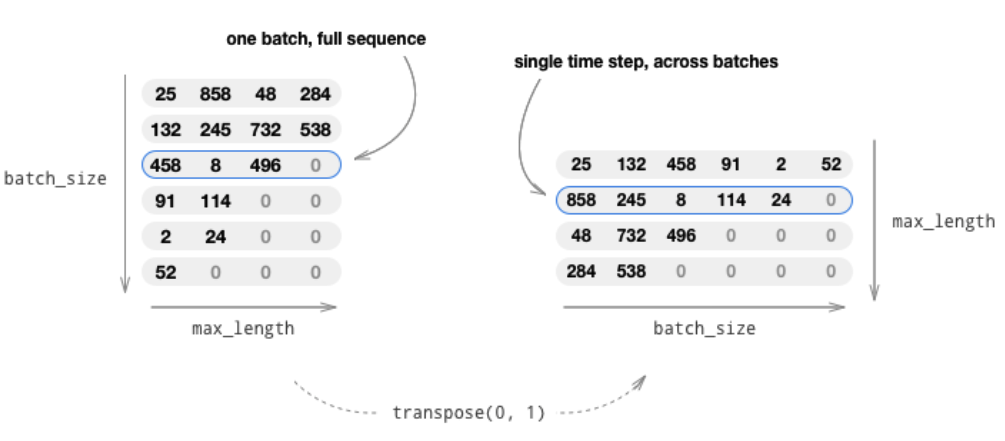

In [20]:
from IPython.display import Image
Image(filename="./figure/1.png", width=800, height=800)

 因此我们会用一些工具函数来实现上述处理。

inputVar函数把batch个句子padding后变成一个LongTensor，大小是(max_length, batch)，同时会返回一个大小是batch的list lengths，说明每个句子的实际长度，这个参数后面会传给PyTorch，从而在forward和backward计算的时候使用实际的长度。

outputVar函数和inputVar类似，但是它输出的第二个参数不是lengths，而是一个大小为(max_length, batch)的mask矩阵(tensor)，某位是0表示这个位置是padding，1表示不是padding，这样做的目的是后面计算方便。当然这两种表示是等价的，只不过lengths表示更加紧凑，但是计算起来不同方便，而mask矩阵和outputVar直接相乘就可以把padding的位置给mask(变成0)掉，这在计算loss时会非常方便。

batch2TrainData 则利用上面的两个函数把一个batch的句对处理成合适的输入和输出Tensor。



In [15]:
# 把句子的词变成ID
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

# l是多个长度不同句子(list)，使用zip_longest padding成定长，长度为最长句子的长度。
def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

# l是二维的padding后的list
# 返回m和l的大小一样，如果某个位置是padding，那么值为0，否则为1
def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# 把输入句子变成ID，然后再padding，同时返回lengths这个list，标识实际长度。
# 返回的padVar是一个LongTensor，shape是(batch, max_length)，
# lengths是一个list，长度为(batch,)，表示每个句子的实际长度。
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# 对输出句子进行padding，然后用binaryMatrix得到每个位置是padding(0)还是非padding，
# 同时返回最大最长句子的长度(也就是padding后的长度)
# 返回值padVar是LongTensor，shape是(batch, max_target_length)
# mask是ByteTensor，shape也是(batch, max_target_length)
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# 处理一个batch的pair句对 
def batch2TrainData(voc, pair_batch):
    # 按照句子的长度(词数)排序
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# 示例
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)


input_variable: tensor([[ 147,   94,  318, 4475, 3138],
        [  68,  117,   38, 4477,   76],
        [   7,  746,  266,    6,    6],
        [  24,   53,    2,    2,    2],
        [  25, 3314,    0,    0,    0],
        [ 102,    4,    0,    0,    0],
        [ 159,    2,    0,    0,    0],
        [   6,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([9, 7, 4, 4, 4])
target_variable: tensor([[6324,   64,   27,    7,   25],
        [ 279, 3568,   94, 1004,  348],
        [  83,   68,  542,  315,   25],
        [   4,   45,    2,   36,  534],
        [   2,   95,    0,    6, 4430],
        [   0,  138,    0,    2,  135],
        [   0,  886,    0,    0,    2],
        [   0, 3314,    0,    0,    0],
        [   0,    4,    0,    0,    0],
        [   0,    2,    0,    0,    0]])
mask: tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1],
        [0, 1, 0

我们可以看到input_variable的每一列表示一个样本，而每一行表示batch(5)个样本在这个时刻的值。

而lengths表示真实的长度。类似的target_variable也是每一列表示一个样本，而mask的shape和target_variable一样，如果某个位置是0，则表示padding。

# 定义模型

我们这个chatbot的核心是一个sequence-to-sequence(seq2seq)模型。 seq2seq模型的输入是一个变长的序列，而输出也是一个变长的序列。而且这两个序列的长度并不相同。一般我们使用RNN来处理变长的序列，Sutskever等人的论文发现通过使用两个RNN可以解决这类问题。

这类问题的输入和输出都是变长的而且长度不一样，包括问答系统、机器翻译、自动摘要等等都可以使用seq2seq模型来解决。其中一个RNN叫做Encoder，它把变长的输入序列编码成一个固定长度的context向量，我们一般可以认为这个向量包含了输入句子的语义。

而第二个RNN叫做Decoder，初始隐状态是Encoder的输出context向量，输入是(表示句子开始的特殊Token)，然后用RNN计算第一个时刻的输出，接着用第一个时刻的输出和隐状态计算第二个时刻的输出和新的隐状态，...，直到某个时刻输出特殊的(表示句子结束的特殊Token)或者长度超过一个阈值。

Seq2Seq模型如下图所示。

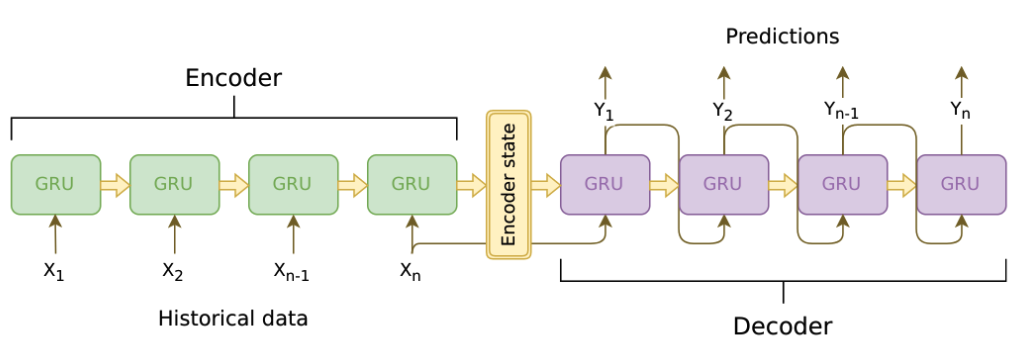

In [19]:
from IPython.display import Image
Image(filename="./figure/2.png", width=800, height=800)

## Encoder

Encoder是个RNN，它会遍历输入的每一个Token(词)，每个时刻的输入是上一个时刻的隐状态和输入，然后会有一个输出和新的隐状态。这个新的隐状态会作为下一个时刻的输入隐状态。

每个时刻都有一个输出，对于seq2seq模型来说，我们通常只保留最后一个时刻的隐状态，认为它编码了整个句子的语义，

但是后面我们会用到Attention机制，它还会用到Encoder每个时刻的输出。Encoder处理结束后会把最后一个时刻的隐状态作为Decoder的初始隐状态。

我们会使用双向的RNN，如下图所示。

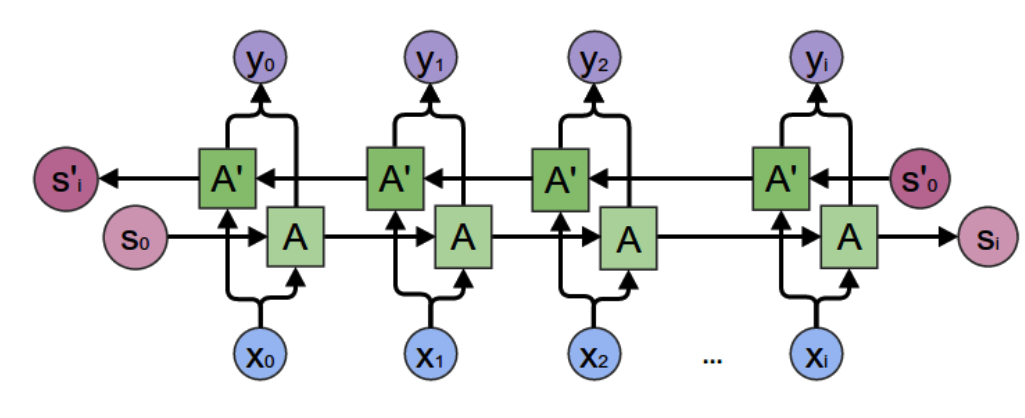

In [21]:
from IPython.display import Image
Image(filename="./figure/3.png", width=800, height=800)

注意在接入RNN之前会有一个embedding层，用来把每一个词(ID或者one-hot向量)映射成一个连续的稠密的向量，我们可以认为这个向量编码了一个词的语义。在我们的模型里，我们把它的大小定义成和RNN的隐状态大小一样(但是并不是一定要一样)。有了Embedding之后，模型会把相似的词编码成相似的向量(距离比较近)。

最后，为了把padding的batch数据传给RNN，我们需要使用下面的两个函数来进行pack和unpack，后面我们会详细介绍它们。这两个函数是：
- torch.nn.utils.rnn.pack_padded_sequence
- torch.nn.utils.rnn.pad_packed_sequence

计算过程：
- 1) 把词的ID通过Embedding层变成向量。 
- 2) 把padding后的数据进行pack。 
- 3) 传入GRU进行Forward计算。 
- 4) Unpack计算结果 
- 5) 把双向GRU的结果向量加起来。 
- 6) 返回(所有时刻的)输出和最后时刻的隐状态。

输入:

- input_seq: 一个batch的输入句子，shape是(max_length, batch_size)
- input_lengths: 一个长度为batch的list，表示句子的实际长度。
- hidden: 初始化隐状态(通常是零)，shape是(n_layers x num_directions, batch_size, hidden_size)

输出:

- outputs: 最后一层GRU的输出向量(双向的向量加在了一起)，shape(max_length, batch_size, hidden_size)
- hidden: 最后一个时刻的隐状态，shape是(n_layers x num_directions, batch_size, hidden_size)

EncoderRNN代码如下：

In [22]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # 初始化GRU，这里输入和hidden大小都是hidden_size，这里假设embedding层的输出大小是hidden_size
        # 如果只有一层，那么不进行Dropout，否则使用传入的参数dropout进行GRU的Dropout。
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # 输入是(max_length, batch)，Embedding之后变成(max_length, batch, hidden_size)
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        # 因为RNN(GRU)要知道实际长度，所以PyTorch提供了函数pack_padded_sequence把输入向量和长度
        # pack到一个对象PackedSequence里，这样便于使用。
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # 通过GRU进行forward计算，需要传入输入和隐变量
        # 如果传入的输入是一个Tensor (max_length, batch, hidden_size)
        # 那么输出outputs是(max_length, batch, hidden_size*num_directions)。
        # 第三维是hidden_size和num_directions的混合，它们实际排列顺序是num_directions在前面，
        # 因此我们可以使用outputs.view(seq_len, batch, num_directions, hidden_size)得到4维的向量。
        # 其中第三维是方向，第四位是隐状态。
        
        # 而如果输入是PackedSequence对象，那么输出outputs也是一个PackedSequence对象，我们需要用
        # 函数pad_packed_sequence把它变成shape为(max_length, batch, hidden*num_directions)的向量以及
        # 一个list，表示输出的长度，当然这个list和输入的input_lengths完全一样，因此通常我们不需要它。
        outputs, hidden = self.gru(packed, hidden)
        # 参考前面的注释，我们得到outputs为(max_length, batch, hidden*num_directions)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # 我们需要把输出的num_directions双向的向量加起来
        # 因为outputs的第三维是先放前向的hidden_size个结果，然后再放后向的hidden_size个结果
        # 所以outputs[:, :, :self.hidden_size]得到前向的结果
        # outputs[:, :, self.hidden_size:]是后向的结果
        # 注意，如果bidirectional是False，则outputs第三维的大小就是hidden_size，
        # 这时outputs[:, : ,self.hidden_size:]是不存在的，因此也不会加上去。
        # 对Python slicing不熟的读者可以看看下面的例子：
        
        # >>> a=[1,2,3]
        # >>> a[:3]
        # [1, 2, 3]
        # >>> a[3:]
        # []
        # >>> a[:3]+a[3:]
        # [1, 2, 3]
        
        # 这样就不用写下面的代码了：
        # if bidirectional:
        #     outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # 返回最终的输出和最后时刻的隐状态。 
        return outputs, hidden

## Decoder

Decoder也是一个RNN，它每个时刻输出一个词。每个时刻的输入是上一个时刻的隐状态和上一个时刻的输出。

一开始的隐状态是Encoder最后时刻的隐状态，输入是特殊的。然后使用RNN计算新的隐状态和输出第一个词，接着用新的隐状态和第一个词计算第二个词，...，直到遇到，结束输出。

普通的RNN Decoder的问题是它只依赖与Encoder最后一个时刻的隐状态，虽然理论上这个隐状态(context向量)可以编码输入句子的语义，但是实际会比较困难。因此当输入句子很长的时候，效果会很差。

为了解决这个问题，Bahdanau等人在论文里提出了注意力机制(attention mechanism)，在Decoder进行t时刻计算的时候，除了t-1时刻的隐状态，当前时刻的输入，**注意力机制还可以参考Encoder所有时刻的输入。**

拿机器翻译来说，我们在翻译以句子的第t个词的时候会把注意力机制在某个词上。当然常见的注意力是一种soft的注意力，假设输入有5个词，注意力可能是一个概率，比如(0.6,0.1,0.1,0.1,0.1)，表示当前最关注的是输入的第一个词。同时我们之前也计算出每个时刻的输出向量，假设5个时刻分别是𝑦1,…,𝑦5，那么我们可以用attention概率加权得到当前时刻的context向量0.6𝑦1+0.1𝑦2+…+0.1𝑦5。

注意力有很多方法计算，我们这里介绍Luong等人在论文提出的方法。它是用当前时刻的GRU计算出的新的隐状态来计算注意力得分，首先它用一个score函数计算这个隐状态和Encoder的输出的相似度得分，得分越大，说明越应该注意这个词。然后再用softmax函数把score变成概率。那机器翻译为例，在t时刻，ℎ𝑡表示t时刻的GRU输出的新的隐状态，我们可以认为ℎ𝑡表示当前需要翻译的语义。通过计算ℎ𝑡与𝑦1,…,𝑦𝑛的得分，如果ℎ𝑡与𝑦1的得分很高，那么我们可以认为当前主要翻译词𝑥1的语义。有很多中score函数的计算方法，如下图所示：

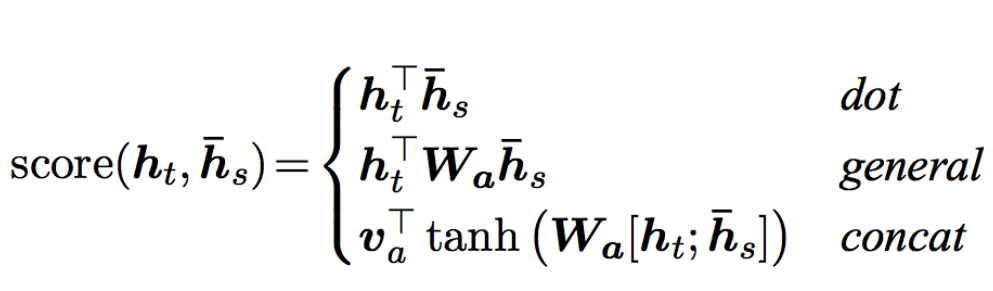

In [23]:
from IPython.display import Image
Image(filename="./figure/4.png", width=800, height=800)

上式中ℎ𝑡表示t时刻的隐状态，比如第一种计算score的方法，直接计算ℎ𝑡与ℎ𝑠的内积，内积越大，说明这两个向量越相似，因此注意力也更多的放到这个词上。第二种方法也类似，只是引入了一个可以学习的矩阵，我们可以认为它先对ℎ𝑡做一个线性变换，然后在与ℎ𝑠计算内积。而第三种方法把它们拼接起来然后用一个全连接网络来计算score。

注意，我们前面介绍的是分别计算ℎ𝑡和𝑦1的内积、ℎ𝑡和𝑦2的内积，…。但是为了效率，可以一次计算ℎ𝑡与ℎ𝑠=[𝑦1,𝑦2,…,𝑦𝑛]的乘积。 。



In [24]:
# Luong 注意力layer
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = torch.nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = torch.nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = torch.nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        # 输入hidden的shape是(1, batch=64, hidden_size=500)
        # encoder_outputs的shape是(input_lengths=10, batch=64, hidden_size=500)
        # hidden * encoder_output得到的shape是(10, 64, 500)，然后对第3维求和就可以计算出score。
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), 
				      encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)
    
    # 输入是上一个时刻的隐状态hidden和所有时刻的Encoder的输出encoder_outputs
    # 输出是注意力的概率，也就是长度为input_lengths的向量，它的和加起来是1。
    def forward(self, hidden, encoder_outputs):
        # 计算注意力的score，输入hidden的shape是(1, batch=64, hidden_size=500)，
        # 表示t时刻batch数据的隐状态
        # encoder_outputs的shape是(input_lengths=10, batch=64, hidden_size=500) 
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            # 计算内积，参考dot_score函数
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        # 把attn_energies从(max_length=10, batch=64)转置成(64, 10)
        attn_energies = attn_energies.t()

        # 使用softmax函数把score变成概率，shape仍然是(64, 10)，然后用unsqueeze(1)变成
        # (64, 1, 10) 
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

上面的代码实现了dot、general和concat三种score计算方法，分别和前面的三个公式对应

有了注意力的子模块之后，我们就可以实现Decoder了。Encoder可以一次把一个序列输入GRU，得到整个序列的输出。但是Decoder t时刻的输入是t-1时刻的输出，在t-1时刻计算完成之前是未知的，因此只能一次处理一个时刻的数据。

因此Encoder的GRU的输入是(max_length, batch, hidden_size)，而Decoder的输入是(1, batch, hidden_size)。

此外Decoder只能利用前面的信息，所以只能使用单向(而不是双向)的GRU，而Encoder的GRU是双向的，如果两种的hidden_size是一样的，则Decoder的隐单元个数少了一半，那怎么把Encoder的最后时刻的隐状态作为Decoder的初始隐状态呢？

这里是把每个时刻双向结果加起来的，因此它们的大小就能匹配了（请读者参考前面Encoder双向相加的部分代码）。

计算图：
- 1) 把词ID输入Embedding层 
- 2) 使用单向的GRU继续Forward进行一个时刻的计算。 
- 3) 使用新的隐状态计算注意力权重 
- 4) 用注意力权重得到context向量 
- 5) context向量和GRU的输出拼接起来，然后再经过一个全连接网络，使得输出大小仍然是hidden_size 
- 6) 使用一个投影矩阵把输出从hidden_size变成词典大小，然后用softmax变成概率 
- 7) 返回输出和新的隐状态



输入：
- input_step: shape是(1, batch_size)
- last_hidden: 上一个时刻的隐状态， shape是(n_layers x num_directions, batch_size, hidden_size)
- encoder_outputs: encoder的输出， shape是(max_length, batch_size, hidden_size)

In [25]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # 保存到self里，attn_model就是前面定义的Attn类的对象。
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # 定义Decoder的layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # 注意：decoder每一步只能处理一个时刻的数据，因为t时刻计算完了才能计算t+1时刻。
        # input_step的shape是(1, 64)，64是batch，1是当前输入的词ID(来自上一个时刻的输出)
        # 通过embedding层变成(1, 64, 500)，然后进行dropout，shape不变。
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # 把embedded传入GRU进行forward计算
        # 得到rnn_output的shape是(1, 64, 500)
        # hidden是(2, 64, 500)，因为是两层的GRU，所以第一维是2。
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # 计算注意力权重， 根据前面的分析，attn_weights的shape是(64, 1, 10)
        attn_weights = self.attn(rnn_output, encoder_outputs)
        
        # encoder_outputs是(10, 64, 500) 
        # encoder_outputs.transpose(0, 1)后的shape是(64, 10, 500)
        # attn_weights.bmm后是(64, 1, 500)
        
        # bmm是批量的矩阵乘法，第一维是batch，我们可以把attn_weights看成64个(1,10)的矩阵
        # 把encoder_outputs.transpose(0, 1)看成64个(10, 500)的矩阵
        # 那么bmm就是64个(1, 10)矩阵 x (10, 500)矩阵，最终得到(64, 1, 500)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # 把context向量和GRU的输出拼接起来
        # rnn_output从(1, 64, 500)变成(64, 500)
        rnn_output = rnn_output.squeeze(0)
        # context从(64, 1, 500)变成(64, 500)
        context = context.squeeze(1)
        # 拼接得到(64, 1000)
        concat_input = torch.cat((rnn_output, context), 1)
        # self.concat是一个矩阵(1000, 500)，
        # self.concat(concat_input)的输出是(64, 500)
        # 然后用tanh把输出返回变成(-1,1)，concat_output的shape是(64, 500)
        concat_output = torch.tanh(self.concat(concat_input))

        # out是(500, 词典大小=7826)    
        output = self.out(concat_output)
        # 用softmax变成概率，表示当前时刻输出每个词的概率。
        output = F.softmax(output, dim=1)
        # 返回 output和新的隐状态 
        return output, hidden

##  定义训练过程

## Masked 损失

forward实现之后，我们就需要计算loss。seq2seq有两个RNN，Encoder RNN是没有直接定义损失函数的，它是通过影响Decoder从而影响最终的输出以及loss。

Decoder输出一个序列，前面我们介绍的是Decoder在预测时的过程，它的长度是不固定的，只有遇到EOS才结束。给定一个问答句对，我们可以把问题输入Encoder，然后用Decoder得到一个输出序列，但是这个输出序列和”真实”的答案长度并不相同。

而且即使长度相同并且语义相似，也很难直接知道预测的答案和真实的答案是否类似。

那么我们怎么计算loss呢？比如输入是”What is your name?”，训练数据中的答案是”I am LiLi”。

假设模型有两种预测：”I am fine”和”My name is LiLi”。从语义上显然第二种答案更好，但是如果字面上比较的话可能第一种更好。

但是让机器知道”I am LiLi”和”My name is LiLi”的语义很接近这是非常困难的，所以实际上我们通常还是通过字面上里进行比较。

我们会限制Decoder的输出，使得Decoder的输出长度和”真实”答案一样，然后逐个时刻比较。

Decoder输出的是每个词的概率分布，因此可以使用交叉熵损失函数。但是这里还有一个问题，
因为是一个batch的数据里有一些是padding的，因此这些位置的预测是没有必要计算loss的，
因此我们需要使用前面的mask矩阵把对应位置的loss去掉，我们可以通过下面的函数来实现计算Masked的loss。

In [26]:
def maskNLLLoss(inp, target, mask):
    # 计算实际的词的个数，因为padding是0，非padding是1，因此sum就可以得到词的个数
    nTotal = mask.sum()
    
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

上面的代码有几个需要注意的地方。首先是masked_select函数，我们来看一个例子：



In [27]:
x = torch.randn(3, 4)
print("x:",x)
mask = x.ge(0.5)
print("mask:",mask)
res = torch.masked_select(x, mask)
print("res:",res)

x: tensor([[ 0.3252,  1.4716,  0.0217, -0.4123],
        [ 1.7617,  1.2460, -0.2314,  1.7477],
        [ 1.4859,  1.0349,  1.4949,  1.6096]])
mask: tensor([[False,  True, False, False],
        [ True,  True, False,  True],
        [ True,  True,  True,  True]])
res: tensor([1.4716, 1.7617, 1.2460, 1.7477, 1.4859, 1.0349, 1.4949, 1.6096])


它要求mask和被mask的tensor的shape是一样的，然后从crossEntropy选出mask值为1的那些值。输出的维度会减1。

**另外为了实现交叉熵这里使用了gather函数，这是一种比较底层的实现方法，更简便的方法应该使用CrossEntropyLoss或者NLLLoss，其中CrossEntropy等价与LogSoftmax+NLLLoss。**

交叉熵的定义为：𝐻(𝑝,𝑞)=−∑𝑥𝑝(𝑥)𝑙𝑜𝑔𝑞(𝑥)。

**其中p和q是两个随机变量的概率分布，这里是离散的随机变量，如果是连续的需要把求和变成积分。在我们这里p是真实的分布，也就是one-hot的，而q是模型预测的softmax的输出。因为p是one-hot的，所以只需要计算真实分类对应的那个值。**

比如假设一个5分类的问题，当前正确分类是2(下标从0-4)，而模型的预测是(0.1,0.1,0.4,0.2,0.2)，则H=-log(0.4)。用交叉熵作为分类的Loss是比较合理的，正确的分类是2，那么模型在下标为2的地方预测的概率𝑞2越大，则−𝑙𝑜𝑔𝑞2越小，也就是loss越小。

假设inp是：

0.3 0.2 0.4 0.1

0.2 0.1 0.4 0.3

也就是batch=2，而分类数(词典大小)是4，inp是模型预测的分类概率。 

而target = [2,3] ，表示第一个样本的正确分类是第三个类别(概率是0.4），第二个样本的正确分类是第四个类别(概率是0.3)。

因此我们需要计算的是 -log(0.4) - log(0.3)。

怎么不用for循环求出来呢？我们可以使用torch.gather函数首先把0.4和0.3选出来：

In [37]:
inp = torch.tensor([[0.3, 0.2, 0.4, 0.1], [0.2, 0.1, 0.4, 0.3]])
target = torch.tensor([2, 3])
selected = torch.gather(inp, 1, target.view(-1, 1))
# 也就是先将target转换为(2,1)维度的向量，然后再用gather去inp向量中取对应Index的值
print("输出:",selected)


输出: tensor([[0.4000],
        [0.3000]])


## 一次迭代训练的过程

函数train实现一个batch数据的训练。前面我们提到过，在训练的时候我们会限制Decoder的输出，使得Decoder的输出长度和”真实”答案一样长。

但是我们在训练的时候如果让Decoder自行输出，那么收敛可能会比较慢，因为Decoder在t时刻的输入来自t-1时刻的输出。

如果前面预测错了，那么后面很可能都会错下去。另外一种方法叫做teacher forcing，它不管模型在t-1时刻做什么预测都把t-1时刻的正确答案作为t时刻的输入。

但是如果只用teacher forcing也有问题，因为在真实的Decoder里是没有老师来帮它纠正错误的。所以比较好的方法是更加一个teacher_forcing_ratio参数随机的来确定本次训练是否teacher forcing。

另外使用到的一个技巧是梯度裁剪(gradient clipping) 。这个技巧通常是为了防止梯度爆炸(exploding gradient)，它把参数限制在一个范围之内，从而可以避免梯度的梯度过大或者出现NaN等问题。

注意：虽然它的名字叫梯度裁剪，但实际它是对模型的参数进行裁剪，它把整个参数看成一个向量，如果这个向量的模大于max_norm，那么就把这个向量除以一个值使得模等于max_norm，因此也等价于把这个向量投影到半径为max_norm的球上。

### 操作步骤

- 1) 把整个batch的输入传入encoder 
- 2) 把decoder的输入设置为特殊的，初始隐状态设置为encoder最后时刻的隐状态 
- 3) decoder每次处理一个时刻的forward计算 
- 4) 如果是teacher forcing，把上个时刻的"正确的"词作为当前输入，否则用上一个时刻的输出作为当前时刻的输入 
- 5) 计算loss 
- 6) 反向计算梯度 
- 7) 对梯度进行裁剪 
- 8) 更新模型(包括encoder和decoder)参数

注意，PyTorch的RNN模块(RNN, LSTM, GRU)也可以当成普通的非循环的网络来使用。在Encoder部分，我们是直接把所有时刻的数据都传入RNN，让它一次计算出所有的结果，但是在Decoder的时候(非teacher forcing)后一个时刻的输入来自前一个时刻的输出，因此无法一次计算。

In [38]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # 梯度清空
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # 设置device，从而支持GPU，当然如果没有GPU也能工作。
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # 初始化变量
    loss = 0
    print_losses = []
    n_totals = 0

    # encoder的Forward计算
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Decoder的初始输入是SOS，我们需要构造(1, batch)的输入，表示第一个时刻batch个输入。
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # 注意：Encoder是双向的，而Decoder是单向的，因此从下往上取n_layers个
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # 确定是否teacher forcing
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # 一次处理一个时刻 
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: 下一个时刻的输入是当前正确答案
            decoder_input = target_variable[t].view(1, -1)
            # 计算累计的loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # 不是teacher forcing: 下一个时刻的输入是当前模型预测概率最高的值
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # 计算累计的loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # 反向计算 
    loss.backward()

    # 对encoder和decoder进行梯度裁剪
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # 更新参数
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

## 训练迭代过程

最后是把前面的代码组合起来进行训练。函数trainIters用于进行n_iterations次minibatch的训练。

值得注意的是我们定期会保存模型，我们会保存一个tar包，包括encoder和decoder的state_dicts(参数),优化器(optimizers)的state_dicts, loss和迭代次数。这样保存模型的好处是从中恢复后我们既可以进行预测也可以进行训练(因为有优化器的参数和迭代的次数)。

In [39]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, 
              embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, 
              print_every, save_every, clip, corpus_name, loadFilename):

    # 随机选择n_iteration个batch的数据(pair)
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # 初始化
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # 训练
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # 训练一个batch的数据
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # 进度
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}"
			.format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # 保存checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'
		.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

## 效果测试

模型训练完成之后，我们需要测试它的效果。最简单直接的方法就是和chatbot来聊天。因此我们需要用Decoder来生成一个响应。

## 贪心解码(Greedy decoding)算法 

最简单的解码算法是贪心算法，也就是每次都选择概率最高的那个词，然后把这个词作为下一个时刻的输入，直到遇到EOS结束解码或者达到一个最大长度。但是贪心算法不一定能得到最优解，因为某个答案可能开始的几个词的概率并不太高，但是后来概率会很大。因此除了贪心算法，我们通常也可以使用Beam-Search算法，也就是每个时刻保留概率最高的Top K个结果，然后下一个时刻尝试把这K个结果输入(当然需要能恢复RNN的状态)，然后再从中选择概率最高的K个。

为了实现贪心解码算法，我们定义一个GreedySearchDecoder类。这个类的forwar的方法需要传入一个输入序列(input_seq)，其shape是(input_seq length, 1)， 输入长度input_length和最大输出长度max_length。就是过程如下：

- 1) 把输入传给Encoder，得到所有时刻的输出和最后一个时刻的隐状态。 
- 2) 把Encoder最后时刻的隐状态作为Decoder的初始状态。 
- 3) Decoder的第一输入初始化为SOS。 
- 4) 定义保存解码结果的tensor 
- 5) 循环直到最大解码长度 
 - a) 把当前输入传入Decoder 
 - b) 得到概率最大的词以及概率 
 - c) 把这个词和概率保存下来 
 - d) 把当前输出的词作为下一个时刻的输入 
- 6) 返回所有的词和概率

In [40]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Encoder的Forward计算 
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # 把Encoder最后时刻的隐状态作为Decoder的初始值
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # 因为我们的函数都是要求(time,batch)，因此即使只有一个数据，也要做出二维的。
        # Decoder的初始输入是SOS
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # 用于保存解码结果的tensor
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # 循环，这里只使用长度限制，后面处理的时候把EOS去掉了。
        for _ in range(max_length):
            # Decoder forward一步
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, 
								encoder_outputs)
            # decoder_outputs是(batch=1, vob_size)
            # 使用max返回概率最大的词和得分
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # 把解码结果保存到all_tokens和all_scores里
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # decoder_input是当前时刻输出的词的ID，这是个一维的向量，因为max会减少一维。
            # 但是decoder要求有一个batch维度，因此用unsqueeze增加batch维度。
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # 返回所有的词和得分。
        return all_tokens, all_scores

## 测试对话函数

解码方法完成后，我们写一个函数来测试从终端输入一个句子然后来看看chatbot的回复。

我们需要用前面的函数来把句子分词，然后变成ID传入解码器，得到输出的ID后再转换成文字。我们会实现一个evaluate函数，由它来完成这些工作。我们需要把一个句子变成输入需要的格式——shape为(batch, max_length)，即使只有一个输入也需要增加一个batch维度。

我们首先把句子分词，然后变成ID的序列，然后转置成合适的格式。此外我们还需要创建一个名为lengths的tensor，虽然只有一个，来表示输入的实际长度。接着我们构造类GreedySearchDecoder的实例searcher，然后用searcher来进行解码得到输出的ID，最后我们把这些ID变成词并且去掉EOS之后的内容。

另外一个evaluateInput函数作为chatbot的用户接口，当运行它的时候，它会首先提示用户输入一个句子，然后使用evaluate来生成回复。然后继续对话直到用户输入”q”或者”quit”。如果用户输入的词不在词典里，我们会输出错误信息(当然还有一种办法是忽略这些词)然后提示用户重新输入。



In [41]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### 把输入的一个batch句子变成id
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # 创建lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # 转置 
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # 放到合适的设备上(比如GPU)
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # 用searcher解码
    tokens, scores = searcher(input_batch, lengths, max_length)
    # ID变成词。
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # 得到用户终端的输入
            input_sentence = input('> ')
            # 是否退出
            if input_sentence == 'q' or input_sentence == 'quit': break
            # 句子归一化
            input_sentence = normalizeString(input_sentence)
            # 生成响应Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # 去掉EOS后面的内容
            words = []
            for word in output_words:
                if word == 'EOS':
                    break
                elif word != 'PAD':
                    words.append(word)
            print('Bot:', ' '.join(words))

        except KeyError:
            print("Error: Encountered unknown word.")

## 训练和测试模型 

最后我们可以来训练模型和进行评测了。

不论是我们像训练模型还是测试对话，我们都需要初始化encoder和decoder模型参数。在下面的代码，我们从头开始训练模型或者从某个checkpoint加载模型。读者可以尝试不同的超参数配置来进行调优。

In [42]:
# 配置模型
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# 从哪个checkpoint恢复，如果是None，那么从头开始训练。
loadFilename = None
checkpoint_iter = 4000
  

# 如果loadFilename不空，则从中加载模型 
if loadFilename:
    # 如果训练和加载是一条机器，那么直接加载 
    checkpoint = torch.load(loadFilename)
    # 否则比如checkpoint是在GPU上得到的，但是我们现在又用CPU来训练或者测试，那么注释掉下面的代码
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# 初始化word embedding
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# 初始化encoder和decoder模型
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, 
				decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# 使用合适的设备
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


## 训练

下面的代码进行训练，我们需要设置一些训练的超参数。初始化优化器，最后调用函数trainIters进行训练。

In [44]:
# 配置训练的超参数和优化器 
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
print_every = 1
save_every = 500

# 设置进入训练模式，从而开启dropout 
encoder.train()
decoder.train()

# 初始化优化器 
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# 开始训练
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, './', n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building optimizers ...
Starting Training!
Initializing ...
Training...


/anaconda3/envs/torch1.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/LegacyDefinitions.cpp:32.)
  
/anaconda3/envs/torch1.4/lib/python3.7/site-packages/torch/autograd/__init__.py:127: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/LegacyDefinitions.cpp:18.)
  allow_unreachable=True)  # allow_unreachable flag


Iteration: 1; Percent complete: 0.0%; Average loss: 8.9781
Iteration: 2; Percent complete: 0.1%; Average loss: 8.8747
Iteration: 3; Percent complete: 0.1%; Average loss: 8.7171
Iteration: 4; Percent complete: 0.1%; Average loss: 8.4507
Iteration: 5; Percent complete: 0.1%; Average loss: 8.0966
Iteration: 6; Percent complete: 0.1%; Average loss: 7.5174
Iteration: 7; Percent complete: 0.2%; Average loss: 7.0467


KeyboardInterrupt: 

## 测试

In [45]:
# 进入eval模式，从而去掉dropout。 
encoder.eval()
decoder.eval()

# 构造searcher对象 
searcher = GreedySearchDecoder(encoder, decoder)

# 测试
evaluateInput(encoder, decoder, searcher, voc)

KeyboardInterrupt: Interrupted by user